# Data assimilation in neXtSIM-DG with NEDAS


## Environment and configuration

In [1]:
import sys
import os
notebook_root = '/home/nextsim-workshop/notebooks-nextsim-workshop2025'
data_root = '/home/nextsim-workshop/data-nextsim-workshop2025'

# temporary solution...will use installed package once develop is merged
sys.path.append(os.path.join(data_root, 'assimilation', 'NEDAS'))

os.environ["UCX_LOG_LEVEL"] = "error"

In [2]:
import numpy as np
from datetime import datetime, timedelta, timezone

import matplotlib.pyplot as plt
import cmocean

##for display of plots with sliders
import ipywidgets as widgets
from IPython.display import display, Image, clear_output

In [3]:
# check how many CPUs are available on your system
os.cpu_count()

8

In [4]:
# Configuration
from NEDAS.config import Config

config_file = os.path.join(notebook_root, 'assimilation', 'config.yml')

c = Config(config_file=config_file,
           nproc=6, ## number of processors; set according to your cpu count
           nens=6,  ## ensemble size
           debug=False,
          )

In [5]:
nt = int((c.time_end - c.time_start) / (c.cycle_period*timedelta(hours=1)))


In [6]:
model = c.models['nextsim.dg']

model

In [7]:
# Analysis scheme: offline filter
from NEDAS.schemes import get_analysis_scheme

scheme = get_analysis_scheme(c)

scheme

## Truth run

In [7]:
run_dir = os.path.join(model.truth_dir, 'run', 'ens_01')
os.system("mkdir -p "+run_dir)

icbc_dir = os.path.join(data_root, 'assimilation', 'icbc')
init_file = os.path.join(icbc_dir, f"restart{c.time_start:%Y-%m-%dT%H:%M:%SZ}.nc")
atmos_forcing_file = os.path.join(icbc_dir, "25km_NH.ERA5.nc")
ocean_forcing_file = os.path.join(icbc_dir, "25km_NH.TOPAZ4.nc")
for file in [init_file, atmos_forcing_file, ocean_forcing_file]:
    os.system(f"ln -fs {file} {run_dir}/.")

c.time = c.time_start
while c.time < c.time_end:
    file = f"restart{c.time:%Y-%m-%dT%H:%M:%SZ}.bin"
    next_file = f"restart{c.next_time:%Y-%m-%dT%H:%M:%SZ}.bin"
    print(f"Running the model from condition {file} to reach {next_file}")

    model.run(path=os.path.join(model.truth_dir, 'run'),
              member=0,
              time=c.time,
              forecast_period=c.cycle_period,
              time_start=c.time_start,
              time_end=c.time_end,
              debug=c.debug,
              **c.job_submit)

    c.time = c.next_time
print("done.")

# clean up
os.system(f"mv {run_dir}/restart*.nc {model.truth_dir}/.")
tmp_dir = os.path.join(model.truth_dir, 'run')
os.system(f"rm -rf {tmp_dir}")

Running the model from condition restart2010-01-01T00:00:00Z.bin to reach restart2010-01-01T06:00:00Z.bin
Running the model from condition restart2010-01-01T06:00:00Z.bin to reach restart2010-01-01T12:00:00Z.bin
Running the model from condition restart2010-01-01T12:00:00Z.bin to reach restart2010-01-01T18:00:00Z.bin
Running the model from condition restart2010-01-01T18:00:00Z.bin to reach restart2010-01-02T00:00:00Z.bin
Running the model from condition restart2010-01-02T00:00:00Z.bin to reach restart2010-01-02T06:00:00Z.bin
Running the model from condition restart2010-01-02T06:00:00Z.bin to reach restart2010-01-02T12:00:00Z.bin
Running the model from condition restart2010-01-02T12:00:00Z.bin to reach restart2010-01-02T18:00:00Z.bin
Running the model from condition restart2010-01-02T18:00:00Z.bin to reach restart2010-01-03T00:00:00Z.bin
Running the model from condition restart2010-01-03T00:00:00Z.bin to reach restart2010-01-03T06:00:00Z.bin
Running the model from condition restart2010-0

0

In [9]:
# plot sea ice concentration from truth run, save figures
vname = 'seaice_conc'
vmin = 0
vmax = 1
cmap = cmocean.cm.ice


In [8]:
ny, nx = model.grid.x.shape
true_seaice_thick = np.zeros((nt, ny, nx))
for n in range(nt):
    time = c.time_start + n * c.cycle_period * timedelta(hours=1)
    fld = model.read_var(path=model.truth_dir, time=time, name=vname)
    if n==0:
        model.grid.mask = np.isnan(fld)
    else:
        fld[model.grid.mask] = np.nan
    true_seaice_thick[n, ...] = fld

    fig, ax = plt.subplots(1,1,figsize=(6,5))
    model.grid.plot_field(ax, true_seaice_thick[n,...], vmin, vmax, cmap=cmap)
    model.grid.plot_land(ax, color='gray')
    ax.set_title(f"{vname} {time:%Y-%m-%d %H:%M:%SZ}")

    plt.savefig(os.path.join(model.truth_dir, f"{vname}_{time:%Y-%m-%dT%H:%M:%SZ}.png"))
    plt.close()


In [10]:
# view figures
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=nt-1,
    step=1,
    description='Cycle:',
    continuous_update=False
)
output = widgets.Output()

def update_plot(n):
    with output:
        clear_output(wait=True)
        time = c.time_start + n * c.cycle_period * timedelta(hours=1)
        display(Image(filename=os.path.join(model.truth_dir, f"{vname}_{time:%Y-%m-%dT%H:%M:%SZ}.png")))

widgets.interact(update_plot, n=slider)
display(output)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cycle:', max=15), Output()), _d…

Output()

## Ensemble generation

In [9]:
model.perturb['forcing']['atmosphere']

{'geostrophic_wind_adjust': {'do_adjust': True,
  'u_name': 'data/u',
  'v_name': 'data/v',
  'pres_name': 'data/pair',
  'wind_amp_name': 'data/wind_speed',
  'wind_pert_amp': 1.732050808,
  'type': 'gaussian_evensen',
  'pres_pert_amp': 1.0,
  'hcorr': 250000.0},
 'variables': {'names': ['data/pair',
   'data/sw_in',
   'data/lw_in',
   'data/dew2m',
   'data/tair'],
  'type': ['gaussian_evensen',
   'gaussian_evensen',
   'gaussian_evensen',
   'gaussian_evensen',
   'gaussian_evensen'],
  'amp': [3.16227766, 7.071067812, 7.071067812, 3.0, 3.0],
  'hcorr': [250000.0, 250000.0, 250000.0, 250000.0, 250000.0],
  'tcorr': [48, 48, 48, 48, 48],
  'lower_bounds': ['None', 'None', 'None', 'None', 'None'],
  'upper_bounds': ['None', 'None', 'None', 'None', 'None']}}

In [12]:
# you can change perturbation parameters here
hcorr = 8e5  #horizontal decorrelation length, in meters
tcorr = 168   #temporal decorrelation length, in hours
amp = 1.8    #amplitude of wind perturbation

model.perturb['forcing']['atmosphere']['geostrophic_wind_adjust']['wind_pert_amp'] = amp
model.perturb['forcing']['atmosphere']['geostrophic_wind_adjust']['hcorr'] = hcorr
model.perturb['forcing']['atmosphere']['variables']['hcorr'] = [hcorr, hcorr, hcorr, hcorr, hcorr]
model.perturb['forcing']['atmosphere']['variables']['tcorr'] = [tcorr, tcorr, tcorr, tcorr, tcorr]

In [14]:
# run a cycle without DA analysis (NoDA)
c.time = c.time_start
c.run_analysis = False
scheme(c)

Initializing config...
 working directory: /home/nextsim-workshop/data-nextsim-workshop2025/assimilation
 parallel scheme: nproc = 6, nproc_mem = 6
 cycling from 2010-01-01 00:00:00+00:00 to 2010-01-05 00:00:00+00:00
 analysis start at 2010-01-02 00:00:00+00:00
 cycle_period = 6 hours
 current time: 2010-01-01 00:00:00+00:00
 
Cycling start...

CURRENT CYCLE: 2010-01-01 00:00:00+00:00 => 2010-01-01 06:00:00+00:00

RUNNING preprocess step
Preprocessing nextsim.dg state:
using restart files in /home/nextsim-workshop/data-nextsim-workshop2025/assimilation/icbc
..................................................| 100% done.
timer: preprocess took 9.874282598495483 seconds

RUNNING perturb step
No perturbation defined in config, exiting.
timer: perturb took 0.000194549560546875 seconds

RUNNING ensemble_forecast step
Running nextsim.dg ensemble forecast:
..................................................| 100% done.
timer: ensemble_forecast took 15.4507896900177 seconds

RUNNING diagnose ste

## Forecast error growth

In [14]:
# ensemble spread time series
vname = 'seaice_conc'

rmse = np.zeros(nt)
sprd = np.zeros(nt)

for n in range(nt):
    time = c.time_start + n * c.cycle_period * timedelta(hours=1)
    vartruth = model.read_var(path=model.truth_dir, time=time, name=vname)

    # ensemble mean state
    varmean = np.zeros(c.grid.x.shape)
    for m in range(c.nens):
        var = model.read_var(path=c.forecast_dir(time,'nextsim.dg'), time=time, name=vname, member=m)
        varmean += var
    varmean /= c.nens

    # ensemble spread
    varvar = np.zeros(c.grid.x.shape)
    for m in range(c.nens):
        var = model.read_var(path=c.forecast_dir(time,'nextsim.dg'), time=time, name=vname, member=m)
        varvar += (var - varmean)**2
    varvar = (varvar / (c.nens-1))
    
    rmse[n] = np.sqrt(np.nanmean((varmean - vartruth)**2))
    sprd[n] = np.sqrt(np.nanmean(varvar))

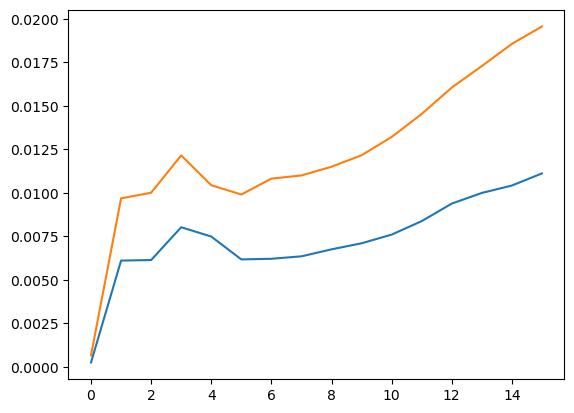

In [15]:
plt.plot(rmse)
plt.plot(sprd)

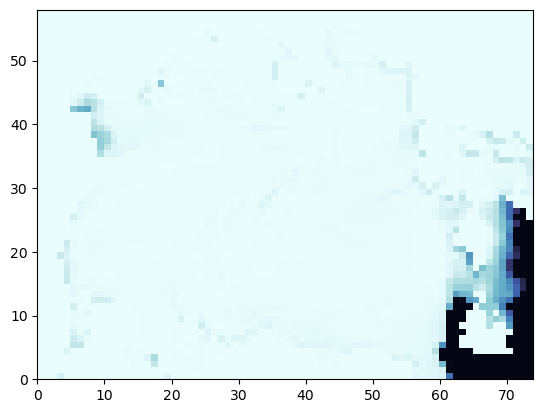

In [16]:
plt.pcolor(vartruth, vmin=0, vmax=1, cmap=cmocean.cm.ice)

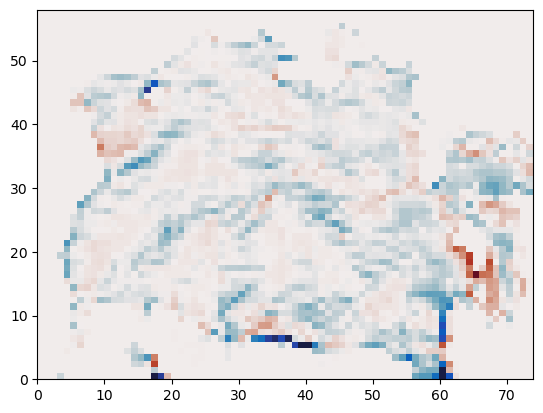

In [18]:
plt.pcolor(varmean-vartruth, vmin=-0.1, vmax=0.1, cmap=cmocean.cm.balance)


## Assimilate single observation

## Cycling DA

In [8]:
c.time = c.time_analysis_start
c.run_analysis = True
scheme(c)

Initializing config...
 working directory: /home/nextsim-workshop/data-nextsim-workshop2025/assimilation
 parallel scheme: nproc = 6, nproc_mem = 6
 cycling from 2010-01-01 00:00:00+00:00 to 2010-01-05 00:00:00+00:00
 analysis start at 2010-01-02 00:00:00+00:00
 cycle_period = 6 hours
 current time: 2010-01-02 00:00:00+00:00
 
Cycling start...

CURRENT CYCLE: 2010-01-02 00:00:00+00:00 => 2010-01-02 06:00:00+00:00

RUNNING preprocess step
Preprocessing nextsim.dg state:
using restart files in /home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle/201001011800/nextsim.dg
..................................................| 100% done.
timer: preprocess took 6.612301826477051 seconds

RUNNING perturb step
No perturbation defined in config, exiting.
timer: perturb took 0.00016355514526367188 seconds

RUNNING filter step
Running analysis for outer iteration step 0:
Running assimilation step in /home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle/201001020000/analys

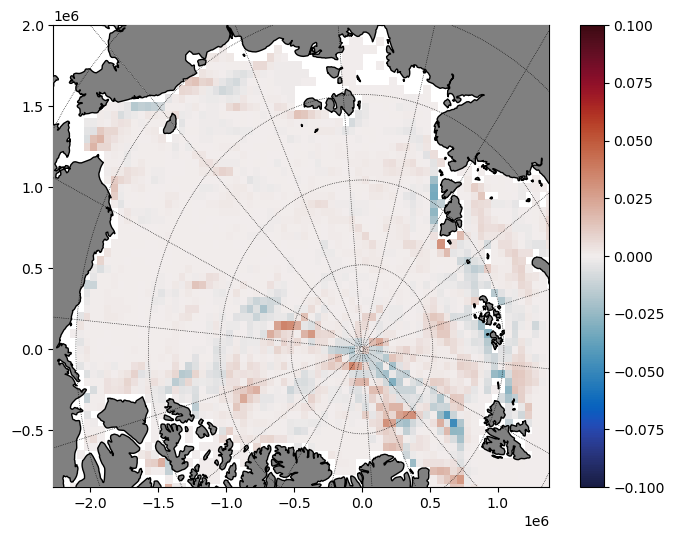

In [12]:
from NEDAS.assim_tools.state import State
state = State(c)

time = c.time_analysis_start

##which field record to show?
varname = 'seaice_conc'
k = 0
rec_id = [i for i,r in state.info['fields'].items() if r['name']==varname and r['k']==k][0]

##which member?
mem_id = 0

path = c.analysis_dir(time)

binfile = os.path.join(path, 'prior_mean_state.bin')
fld0 = state.read_field(binfile, c.grid.mask, mem_id, rec_id)
binfile = os.path.join(path, 'post_mean_state.bin')
fld1 = state.read_field(binfile, c.grid.mask, mem_id, rec_id)

fig, ax = plt.subplots(1, 1, figsize=(8,6))

#im = c.grid.plot_field(ax, (fld1)[...], vmin=0, vmax=1, cmap=cmocean.cm.ice)
im = c.grid.plot_field(ax, (fld1-fld0)[...], vmin=-0.1, vmax=0.1, cmap=cmocean.cm.balance)
plt.colorbar(im)

##obs network
seq = np.load("/home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle/201001020000/analysis/obs_seq.rec0.npy",
              allow_pickle=True).item()
#c.grid.plot_scatter(ax, seq['obs'], x=seq['x'], y=seq['y'], vmin=0, vmax=1, cmap=cmocean.cm.ice, markersize=20)

c.grid.plot_land(ax, color='gray')

In [8]:
##debug,

###something is still not right in the assimilation

c.time = c.time_analysis_start


In [9]:
scheme.preprocess(c)

Preprocessing nextsim.dg state:
using restart files in /home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle/201001011800/nextsim.dg
..................................................| 100% done.


In [10]:
scheme.run_step(c, 'filter', mpi=True)


RUNNING filter step
Running analysis for outer iteration step 0:
Running assimilation step in /home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle/201001020000/analysis/

>>> prepare state by reading fields from model restart
..................................................| 100% done.
>>> compute ensemble mean, save to /home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle/201001020000/analysis/z_coords.bin
..................................................| 100% done.
timer: prepare_state took 0.33227014541625977 seconds
>>> read observation sequence from datasets
number of seaice_conc obs from osisaf.ice_conc: 3000
timer: prepare_obs took 1.3974266052246094 seconds
>>> compute observation priors
..................................................| 100% done.
timer: prepare_obs_from_state took 0.050039052963256836 seconds
>>> compute ensemble mean, save to /home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle/201001020000/analysis/prior_mea

In [11]:
scheme.diagnose(c)

..................................................| 100% done.
